# Analyse the results using arviz

JAXspec provides a convenient way to analyse the results of a fit using the [`arviz`](https://python.arviz.org/en/stable/) library. This library provides powerful tool to explore Bayesian models. In this example, we will show how to use [`arviz`](https://python.arviz.org/en/stable/) to analyse the results of a fit.

In [ ]:
import numpyro

numpyro.enable_x64()
numpyro.set_platform("cpu")
numpyro.set_host_device_count(4)

import numpyro.distributions as dist
from jaxspec.fit import NUTSFitter
from jaxspec.data import ObsConfiguration
from jaxspec.data.util import load_example_obsconf
from jaxspec.model.background import BackgroundWithError
from jaxspec.model.additive import Blackbodyrad, Powerlaw
from jaxspec.model.multiplicative import Tbabs

spectral_model = Tbabs()*(Powerlaw() + Blackbodyrad())

obsconf = load_example_obsconf("NGC7793_ULX4_PN")

prior = {
    "powerlaw_1": {"alpha": dist.Uniform(0., 5.), "norm": dist.Uniform(0., 1e-2)},
    "blackbodyrad_1": {"kT": dist.Uniform(0., 5.), "norm": dist.Uniform(0., 1.)},
    "tbabs_1": {"N_H": dist.Uniform(0., 2.)},
}

fitter = NUTSFitter(spectral_model, prior, obsconf)

result = fitter.fit(
    num_chains=4, 
    num_warmup=1000, 
    num_samples=1000,
    mcmc_kwargs={"progress_bar": True}
)

From the result object, you can access the `inference_data` attribute, which is an `arviz.InferenceData` object. This leverage the use of every arviz function to analyse the results of the fit.

In [2]:
inference_data = result.inference_data
inference_data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

## Trace plot
This visualization is useful to see the evolution of the parameters during the sampling process. It can be used to diagnose convergence issues. The ideal situation is when the chains are well mixed and randomly scattered around the target distribution. If instead, chains are stuck in some region of the parameter space, or show some trends, this might indicate that the sampler did not explore the full parameter space.

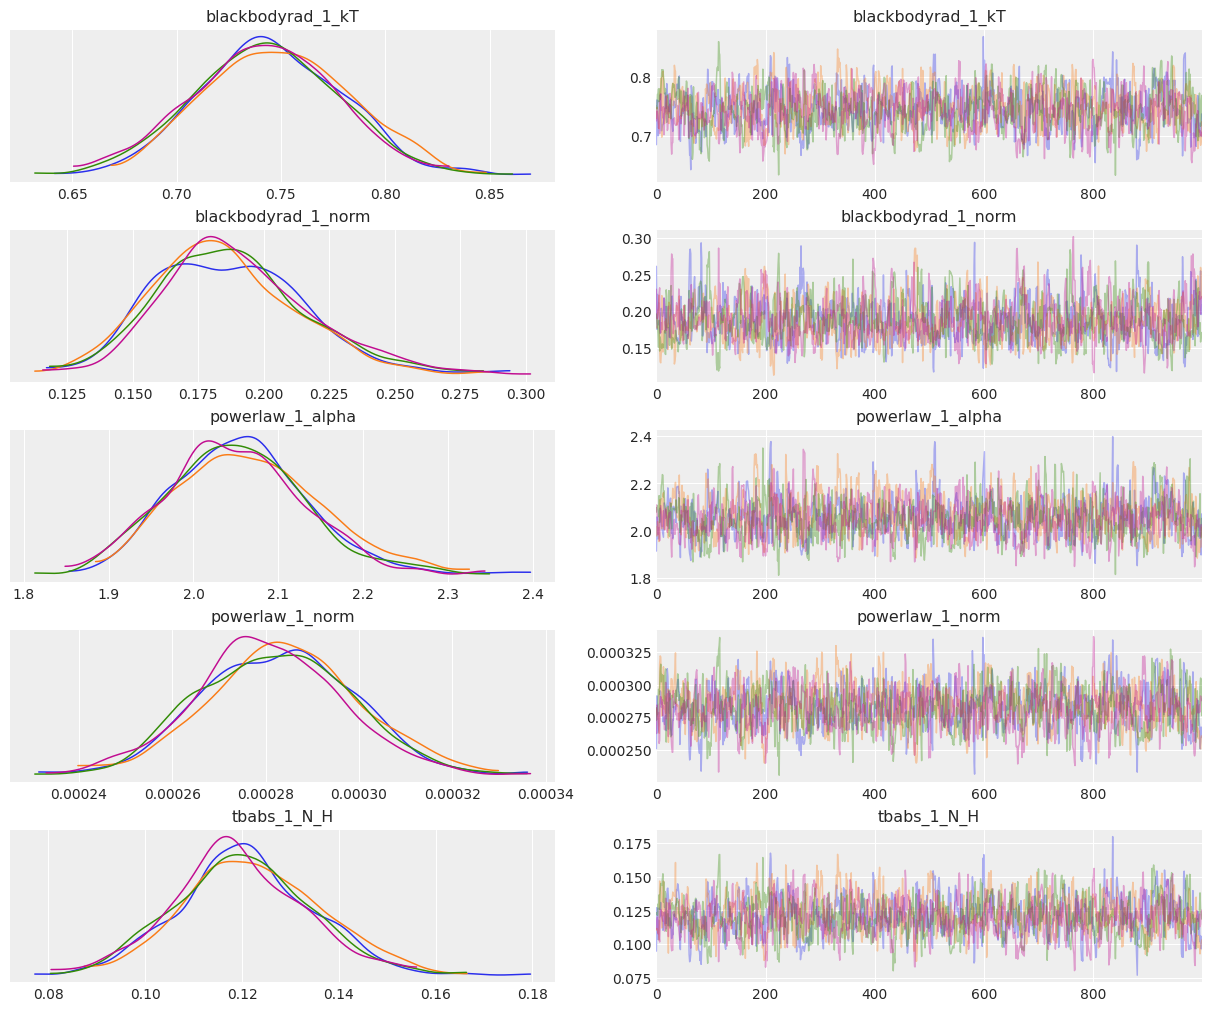

In [3]:
import arviz as az
import matplotlib.pyplot as plt 

with az.style.context("arviz-darkgrid", after_reset=True):
    az.plot_trace(inference_data, compact=False)

plt.show()

A more quantitative way to assess the convergence of the chains is to use the `summary` function. This function provides a summary of the posterior distribution of the parameters, including the mean, the standard deviation, and the 95% highest posterior density interval.

In [4]:
az.summary(result.inference_data.posterior)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
blackbodyrad_1_kT,0.745,0.034,0.683,0.810,0.001,0.001,768.0,1334.0,1.01
blackbodyrad_1_norm,0.187,0.029,0.135,0.242,0.001,0.001,842.0,1238.0,1.00
powerlaw_1_alpha,2.056,0.082,1.909,2.214,0.003,0.002,828.0,1191.0,1.01
powerlaw_1_norm,0.000,0.000,0.000,0.000,0.000,0.000,852.0,1259.0,1.01
tbabs_1_N_H,0.121,0.014,0.096,0.148,0.001,0.000,767.0,1222.0,1.01


The `r_hat` column provides a measure of the convergence of the chains. The closer to 1, the better. A value larger than 1.1 is a sign of convergence issues. This statistic can be directly computed using the `r_hat` function, [see Vehtari et al. (2019)](https://arxiv.org/abs/1903.08008).

In [5]:
rhat = az.rhat(result.inference_data.posterior)
rhat

<xarray.Dataset> Size: 40B
Dimensions:              ()
Data variables:
    blackbodyrad_1_kT    float64 8B 1.006
    blackbodyrad_1_norm  float64 8B 1.004
    powerlaw_1_alpha     float64 8B 1.007
    powerlaw_1_norm      float64 8B 1.006
    tbabs_1_N_H          float64 8B 1.007

## Pair plot

This visualization is useful to see the correlation between the parameters. The ideal situation is when the parameters are uncorrelated, which means that the posterior distribution is close to a multivariate Gaussian distribution.

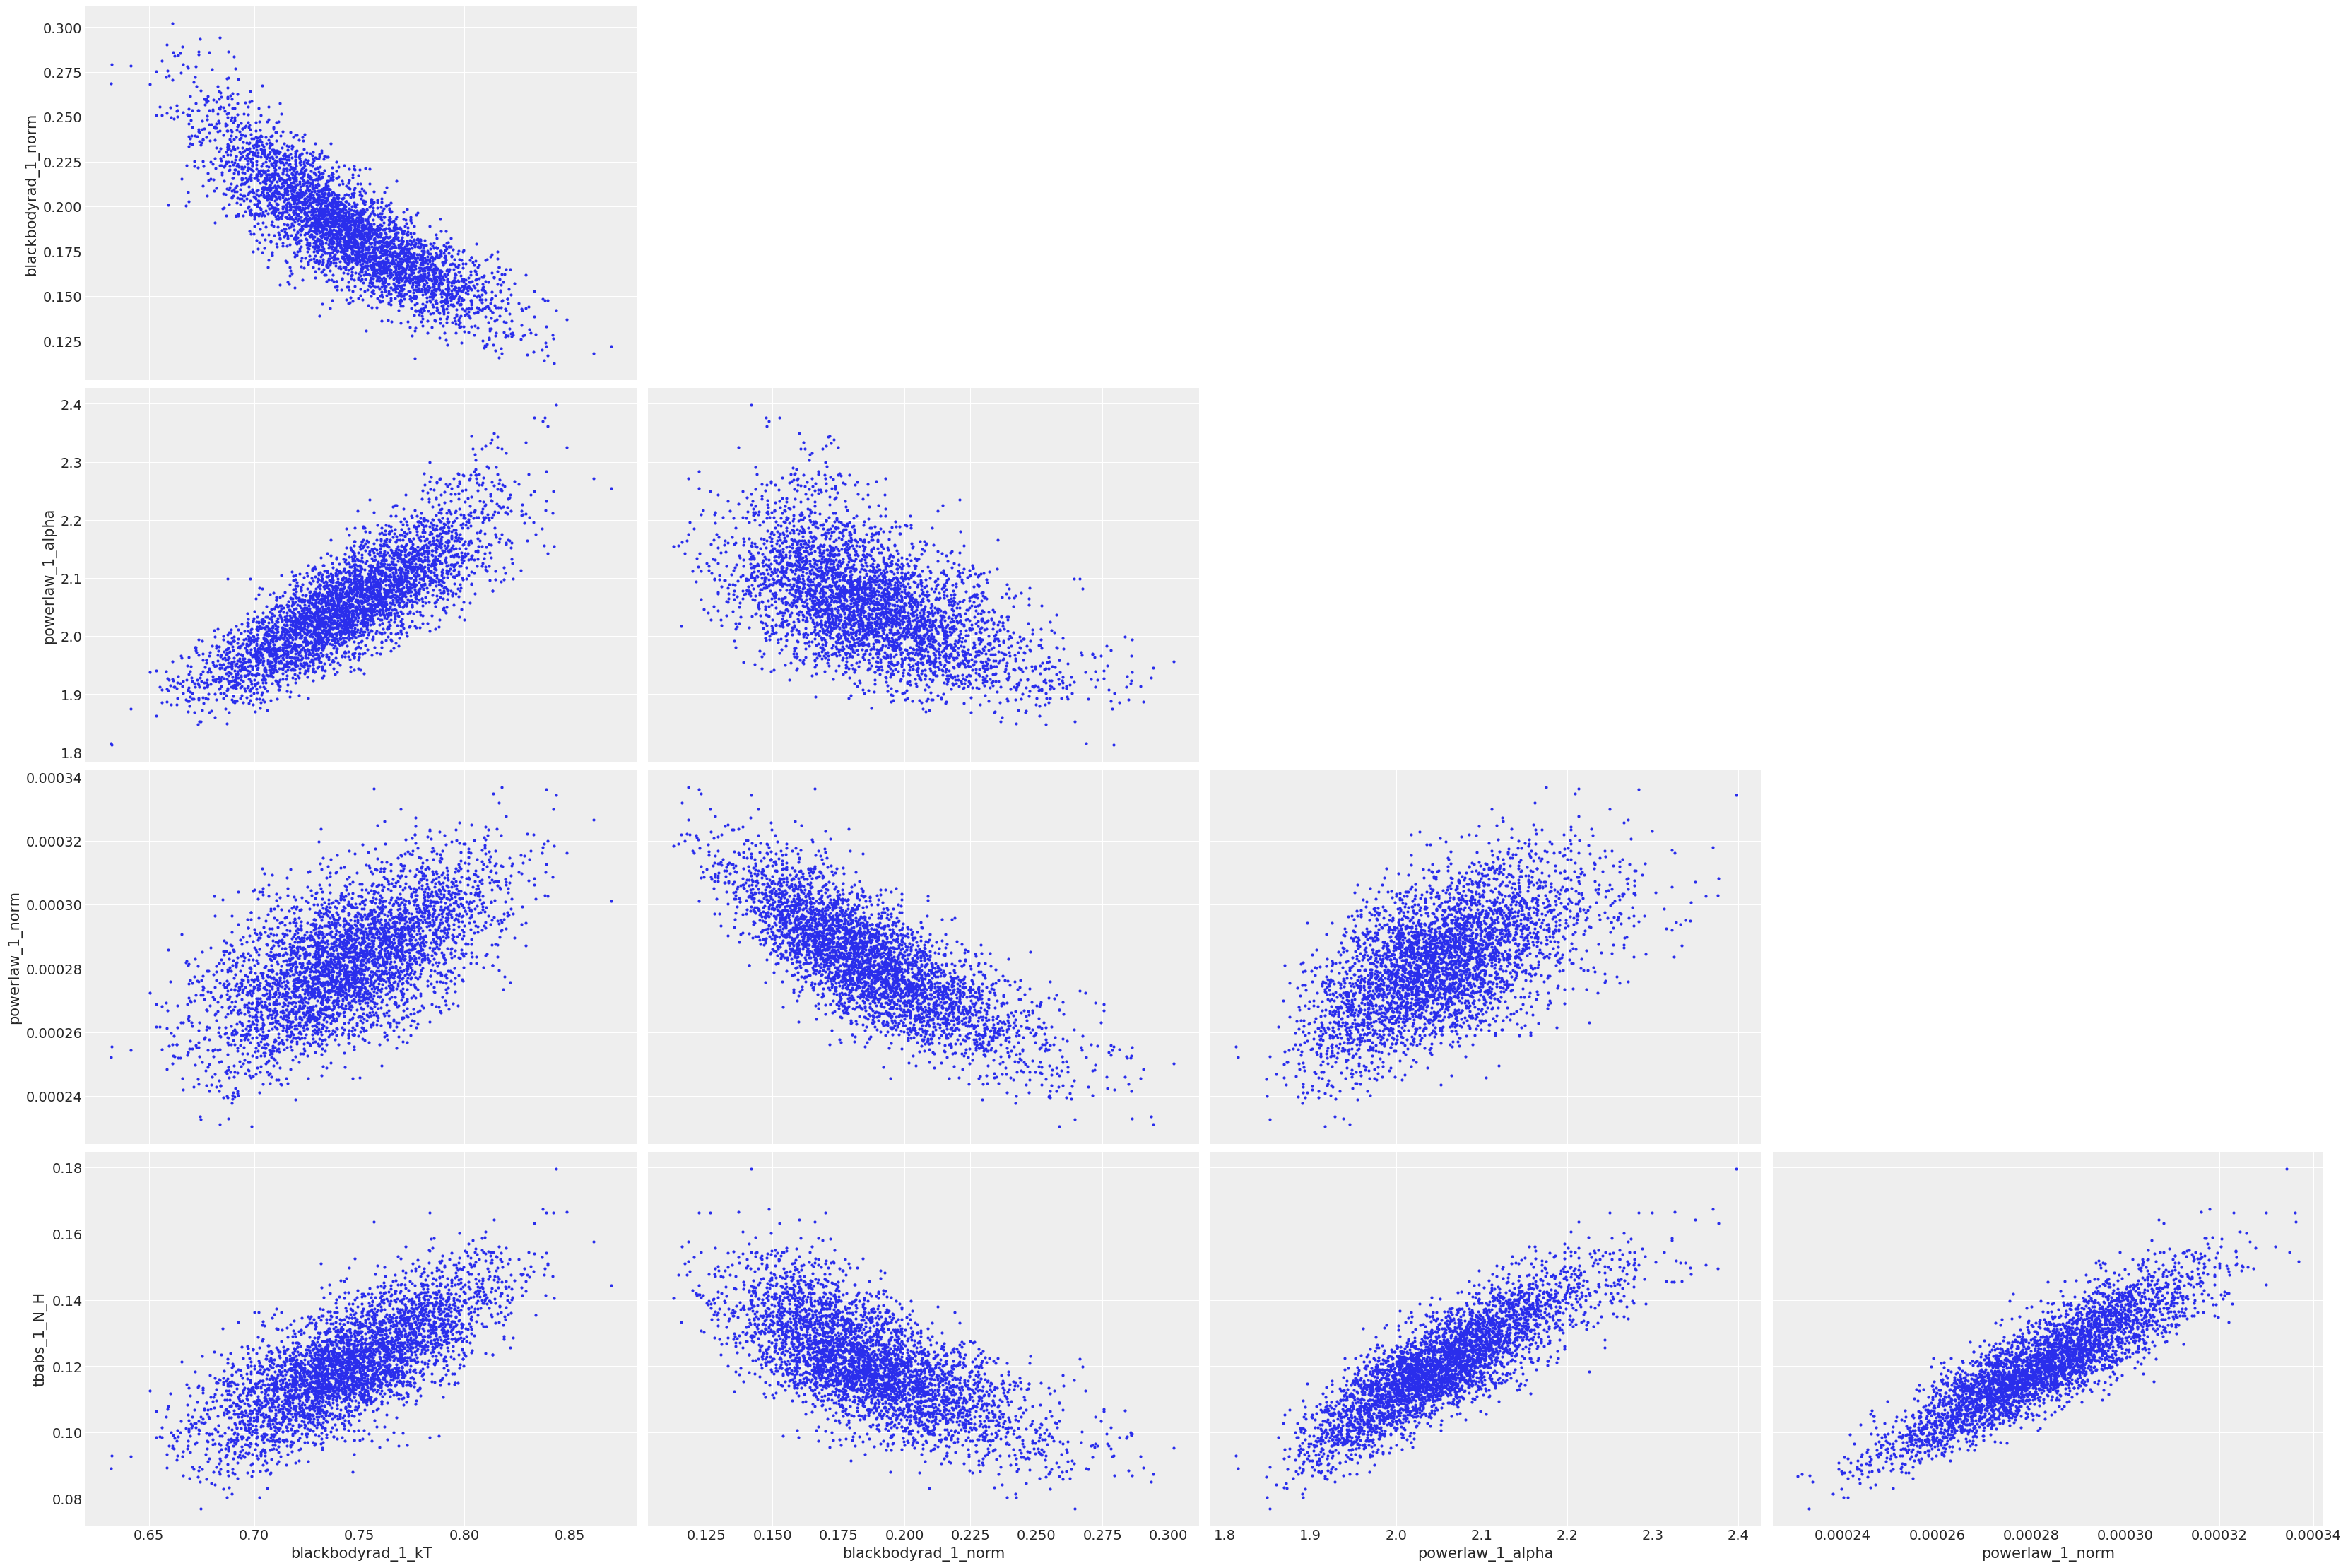

In [6]:
with az.style.context("arviz-darkgrid", after_reset=True):
    az.plot_pair(result.inference_data)
    
plt.show()

Take a look at [arviz's documentation](https://python.arviz.org/en/stable/examples/index.html) to see what else you can do with this library.